# Assignment 08: 
# Text Mining using Dimensionality Reduction Methods [_/100 Marks]

### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



#### In this assignment, we will study apply dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. The dataset for this assignment comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed.



---

In [1]:
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 0

/Users/david/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1 [ / 14 marks]

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. Import the data and use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords. In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [2]:
# Load the data [ /1 marks]
df = pd.read_csv('Reviews_sample.csv')

# Display the first 5 rows [ /1 marks]
df.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=seed
)

vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    stop_words='english',
    sublinear_tf=True,
    min_df=0.05,
    max_df=0.95
)

# Fit and transform the training data
tfidf_train = vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = vectorizer.transform(X_test)

# Create a TfidfTransformer and fit_transform the training data
tfidf_transformer = TfidfTransformer()
train_tfidf_transformed = tfidf_transformer.fit_transform(tfidf_train)

# Transform the test data using the fitted transformer
test_tfidf_transformed = tfidf_transformer.transform(tfidf_test)


# Convert sparse matrices to dense matrices
tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()


From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
# Print the number of indices [ /2 marks]
tfidf_transformer.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37',
       'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46',
       'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55',
       'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63'],
      dtype=object)

### Question 1.2 [ / 12 marks]
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts/components.

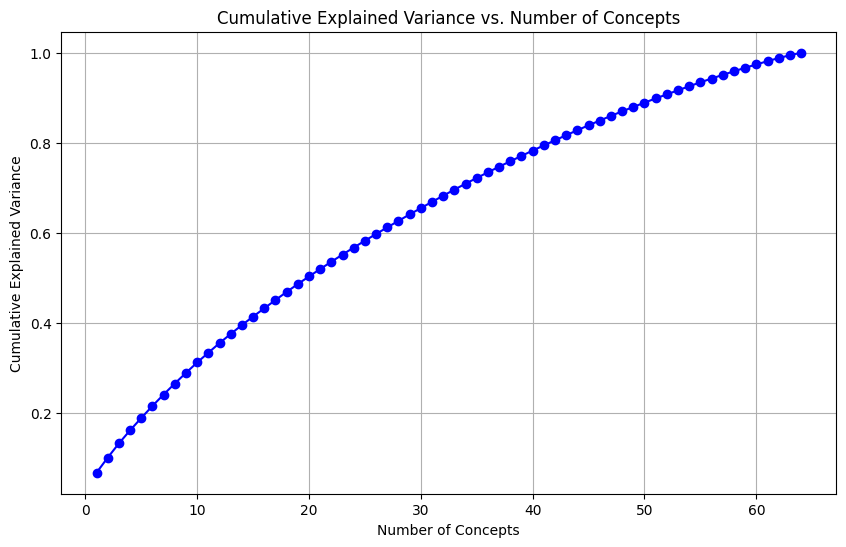

In [5]:
pca = PCA(n_components=train_tfidf_transformed.shape[1])

# Fit the PCA model on the training data
train_pca = pca.fit_transform(np.asarray(tfidf_train))

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance vs. Number of Concepts')
plt.xlabel('Number of Concepts')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

**Written Question:** Exactly how many concepts/components do we need to correctly explain at least 80% of the data? [ /4 marks]


In [6]:
# To get the exact index where the variance is above 80% [ / 4 marks]
np.argmax(cumulative_variance > 0.8)


41

**Your Answer:**  We need exactly 41 concepts.

### Question 1.3 [ / 14 marks]

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [7]:
# Explained variance [ / 2 marks]
# Number of top words to display
top_n = 10

# Function to get the top words for each concept
def get_top_words_for_concept(concept_index, pca_model, vectorizer, top_n):
    concept_weights = pca_model.components_[concept_index]
    top_word_indices = concept_weights.argsort()[-top_n:][::-1]
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_words = feature_names[top_word_indices]
    return top_words

top_three_explained_variance = sum(pca.explained_variance_ratio_[:3])
print('The first three components explain %.2f%% of the variance.' % top_three_explained_variance)

The first three components explain 0.13% of the variance.


In [8]:
# Get 10 most important words for each component [ / 4 marks]
for i in range(pca.components_.shape[0]):
    print(f"Concept {i + 1}")
    top_words = get_top_words_for_concept(i, pca, vectorizer, top_n)
    print(", ".join(top_words))
    print()

Concept 1
book, read, reading, written, hawthorne, books, classic, plot, writing, story

Concept 2
great, love, product, recommend, wear, does, worth, book, years, buy

Concept 3
movie, great, love, good, little, better, really, best, want, bad

Concept 4
good, product, does, need, time, worth, read, buy, bought, lot

Concept 5
just, like, good, great, don, bad, thought, really, say, read

Concept 6
time, read, just, best, novel, better, hawthorne, story, classic, money

Concept 7
like, read, great, really, ve, novel, day, work, written, way

Concept 8
love, really, story, little, good, novel, characters, read, books, think

Concept 9
little, old, really, year, time, like, work, book, money, hard

Concept 10
really, time, don, love, need, movie, thing, want, story, long

Concept 11
old, year, love, read, hard, use, make, good, don, years

Concept 12
like, love, time, wear, best, good, think, novel, did, way

Concept 13
buy, don, bought, love, reading, good, thing, does, like, bad

Conc

In [9]:
# Words for concept 1 [ / 2 marks]
print(f"Concept 1: ", get_top_words_for_concept(0, pca, vectorizer, top_n))

Concept 1:  ['book' 'read' 'reading' 'written' 'hawthorne' 'books' 'classic' 'plot'
 'writing' 'story']


In [10]:
# Words for concept 2 [ / 2 marks
print(f"Concept 2: ", get_top_words_for_concept(1, pca, vectorizer, top_n))


Concept 2:  ['great' 'love' 'product' 'recommend' 'wear' 'does' 'worth' 'book' 'years'
 'buy']


In [11]:
# Words for concept 3 [ / 2 marks
print(f"Concept 3: ", get_top_words_for_concept(2, pca, vectorizer, top_n))


Concept 3:  ['movie' 'great' 'love' 'good' 'little' 'better' 'really' 'best' 'want'
 'bad']



**Written Question:** What is the cumulative variance explained by these three concepts? What would you name each of these concepts? [ / 2 marks]

*Hint: If in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

**Your answer:**  The cumulative variance explained by the first 3 concepts is 0.13%. Possible names for the first three concepts (respectively) could be "Book Review", "Purchase Recommendation", and "Movie Review".

### Question 1.4 [ / 8 marks]

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours.


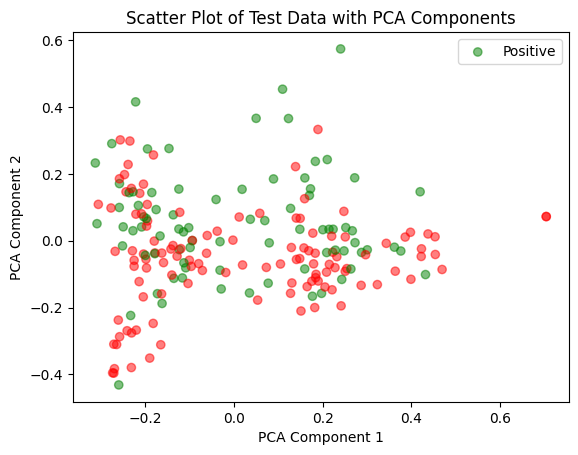

In [12]:
test_pca = pca.transform(np.asarray(tfidf_test))[:, :2]
test_df = pd.DataFrame(data={'PCA1': test_pca[:, 0], 'PCA2': test_pca[:, 1], 'Sentiment': y_test})

colors = {1: 'green', 0: 'red'}
plt.scatter(test_df['PCA1'], test_df['PCA2'], c=test_df['Sentiment'].map(colors), alpha=0.5)
plt.title('Scatter Plot of Test Data with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(['Positive', 'Negative'])
plt.show()



**Written Question:** What can we say about where the positive and negative cases lie in our plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer:** The positive cases are way more scattered and they are mostly located above the negative ones. We cannot use the first two components to discriminate positive and negative cases since a large overlap can be seen for both cases where second component is between -0.2 and 0.

### Question  1.5 [ / 18 marks]

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



/Users/david/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/david/Library/Python/3.9/lib/python/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/david/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/david/Library/Python/3.9/lib/python/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigen

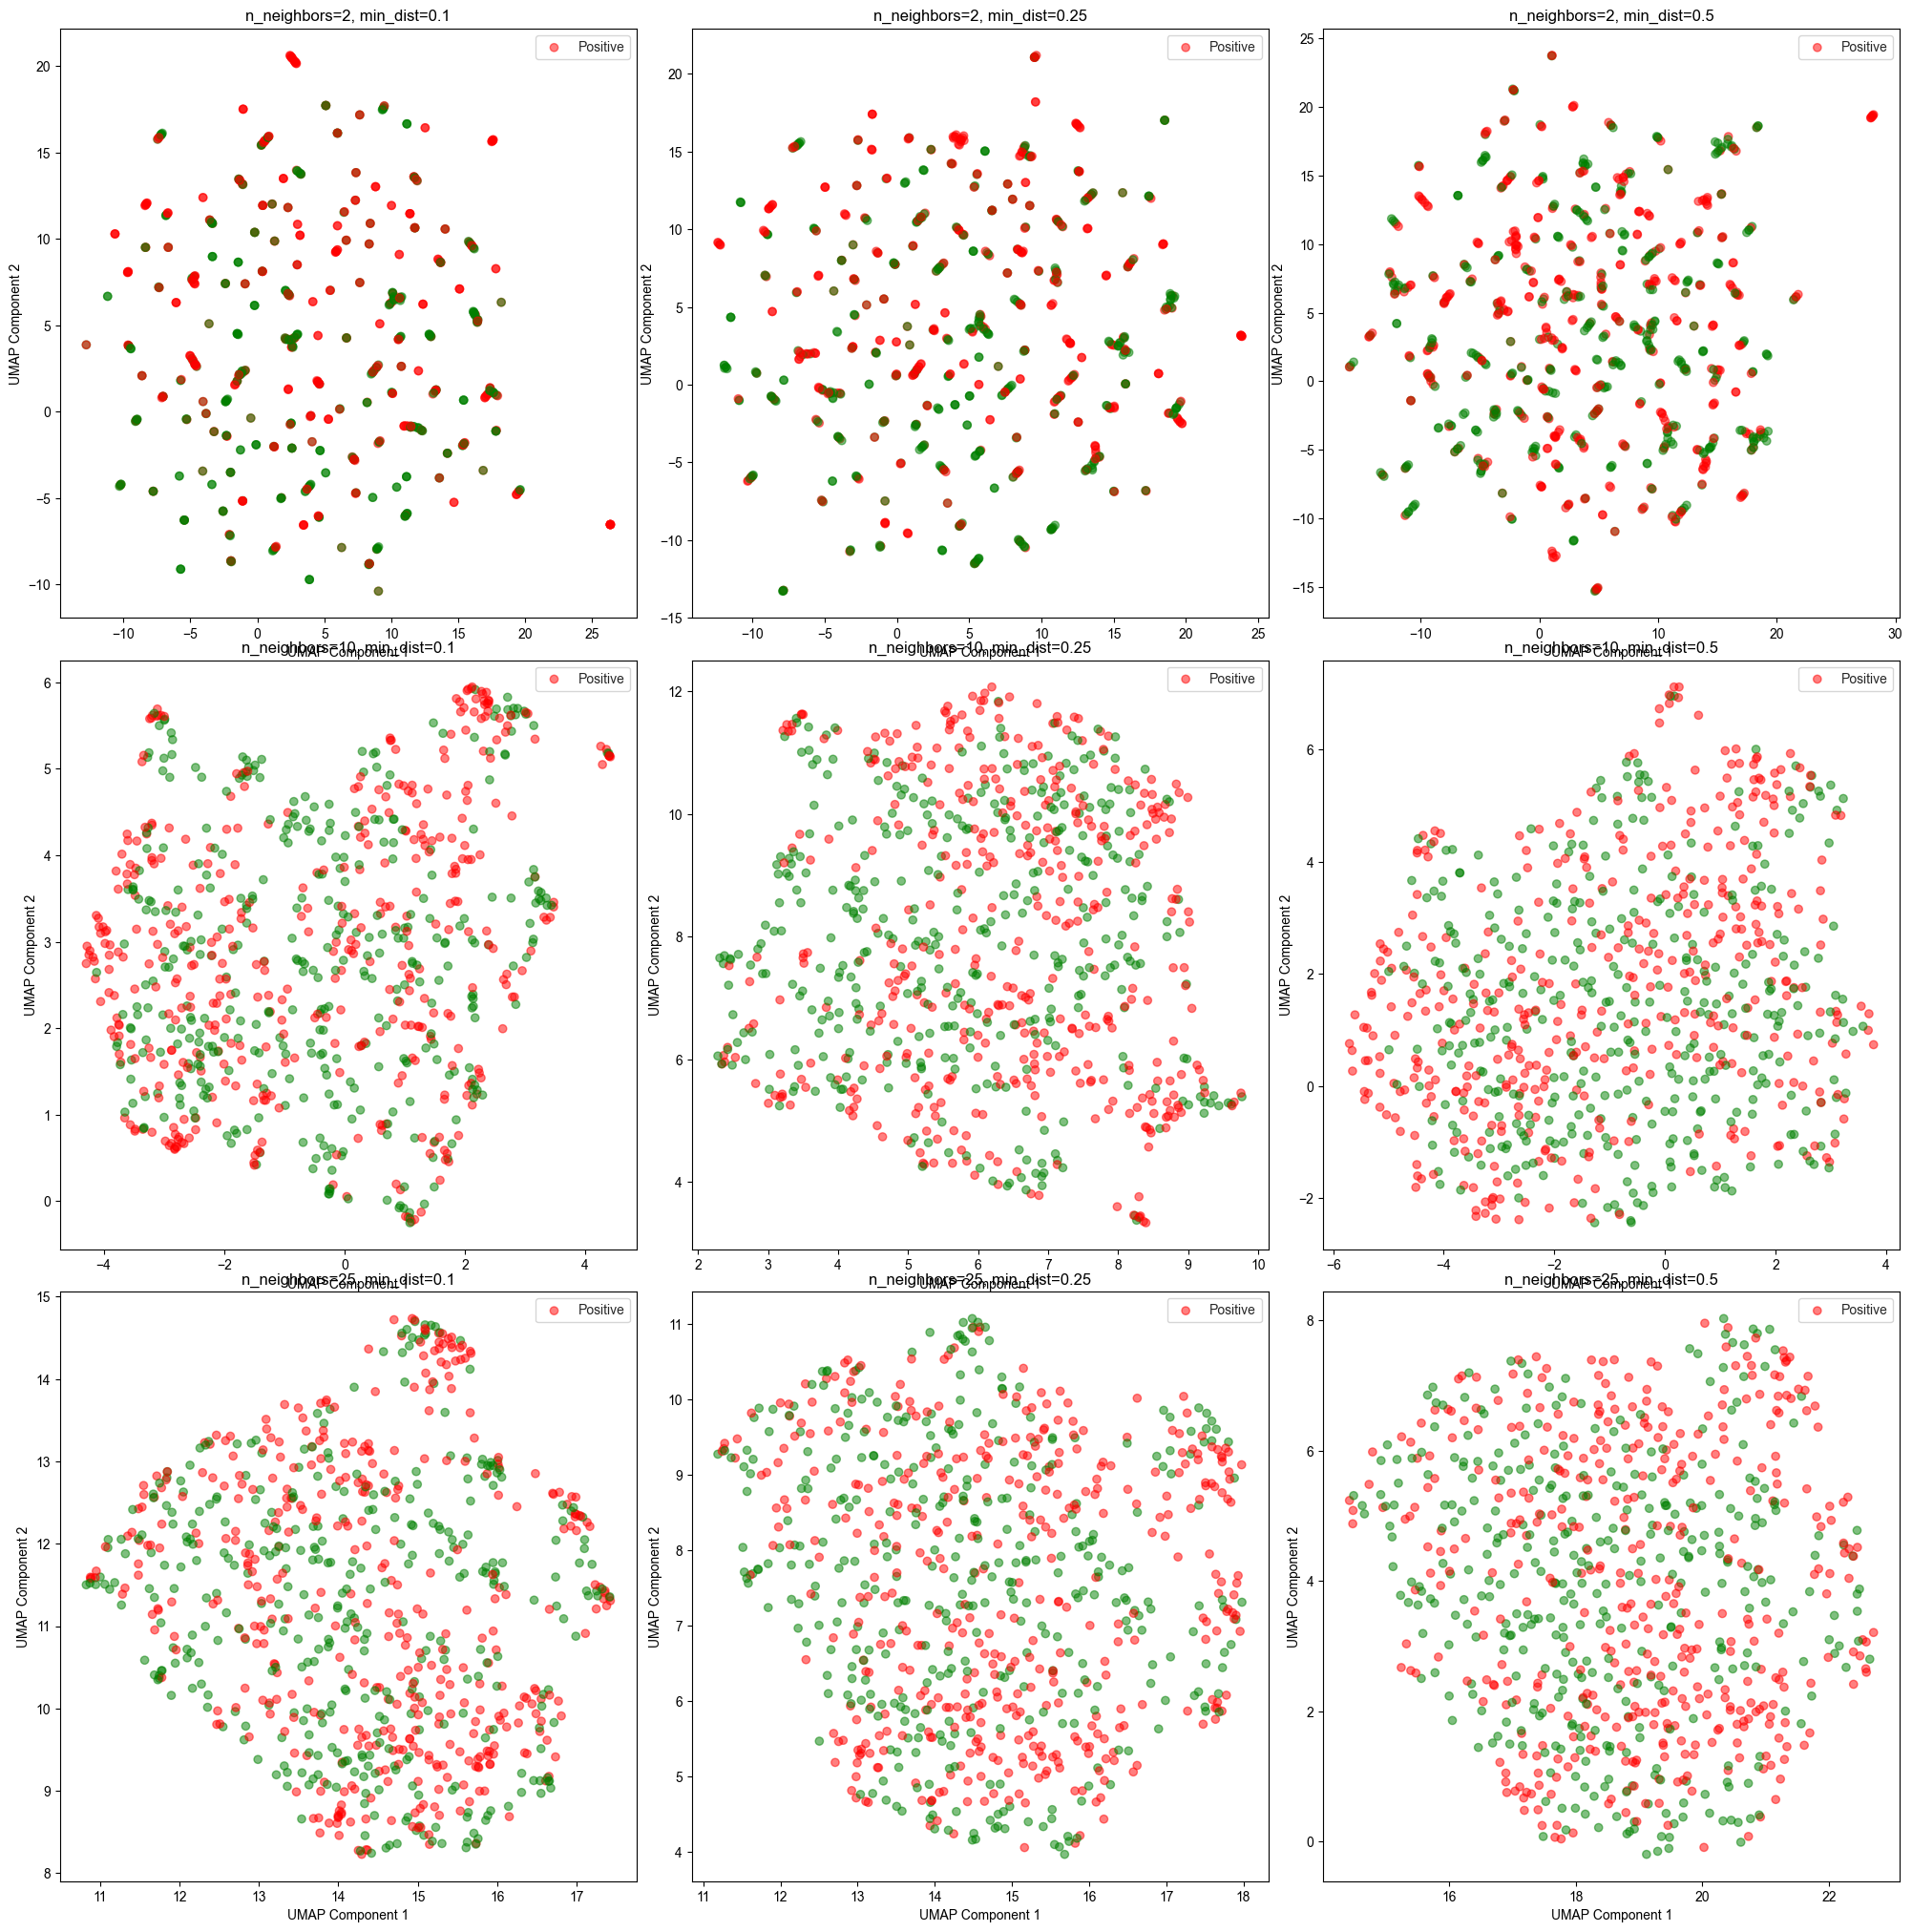

In [13]:
# Set parameters
fig, axs = plt.subplots(3, 3, figsize=(20,20))
n_neighbors=[2, 10, 25]
min_dist=[0.1, 0.25, 0.5]
fig.tight_layout()
sns.set_style('white')

param_grid = {'n_neighbors': [2, 10, 25], 'min_dist': [0.1, 0.25, 0.5]}

best_model = None
best_score = float('inf')
best_model_name = None
best_n_neighbors = None
best_min_dist = None

for i, n_neighbors in enumerate(param_grid['n_neighbors']):
    for j, min_dist in enumerate(param_grid['min_dist']):
        umap_model = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            metric='cosine',
            low_memory=False,
            random_state=seed,
        )
        model_name = f'umap_{n_neighbors}_{min_dist}'
        train_umap = umap_model.fit_transform(np.asarray(tfidf_train))
        score = umap_model.transform(np.asarray(tfidf_train)).sum()
        axs[i, j].scatter(train_umap[:, 0], train_umap[:, 1], c=y_train.map(colors), alpha=0.5)
        axs[i, j].set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        axs[i, j].set_xlabel('UMAP Component 1')
        axs[i, j].set_ylabel('UMAP Component 2')
        axs[i, j].legend(['Positive', 'Negative'])
        if score < best_score:
            best_score = score
            best_model = umap_model
            best_model_name = model_name
            best_n_neighbors = n_neighbors
            best_min_dist = min_dist

In [14]:
print(best_model_name)

umap_10_0.5


**Written Question:** Which paramter would you choose? [ / 2 makrs]

**Your Answer:** I would choose `n_neighbors = 10` and `min_dist=0.5`.

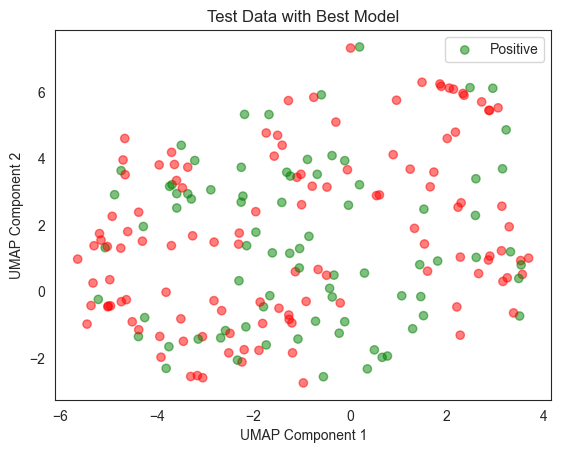

In [15]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]
test_umap = best_model.transform(np.asarray(tfidf_test))

# Create plot [ /2 marks]

plt.scatter(test_umap[:, 0], test_umap[:, 1], c=y_test.map(colors), alpha=0.5)
plt.title('Test Data with Best Model')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(['Positive', 'Negative'])
plt.show()


**Written Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** The data for the different labels are more equally scattered than the PCA one: thus, the UMAP components better explain the variability in the data. 

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 [ /8 marks]
Train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

AUC Score: 0.7283


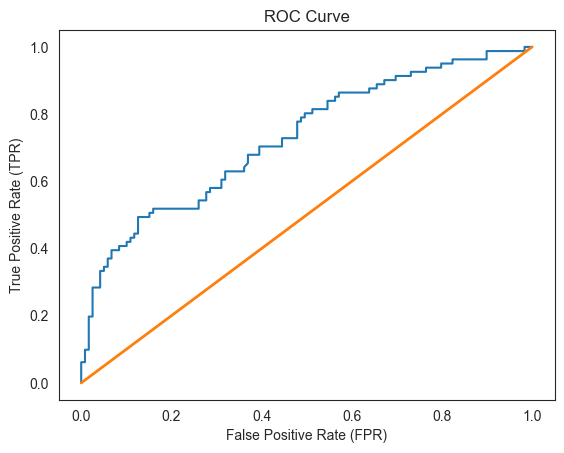

In [16]:
# Train and test using model LogisticRegressionCV [ /4 marks]
logreg = LogisticRegressionCV(penalty='l2', random_state=seed)
logreg.fit(train_tfidf_transformed, y_train)

probas = logreg.predict_proba(np.asarray(tfidf_test))[:, 1]

# Plot ROC curve and compute AUC score [ /4 marks]

auc_score = roc_auc_score(y_test, probas)
print(f'AUC Score: {auc_score:.4f}')
fpr, tpr, thresholds = roc_curve(y_test, probas)

# Create and show the plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], lw=2)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### Question 2.2 [ /12 marks]
Train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

AUC Score (SVD): 0.6995


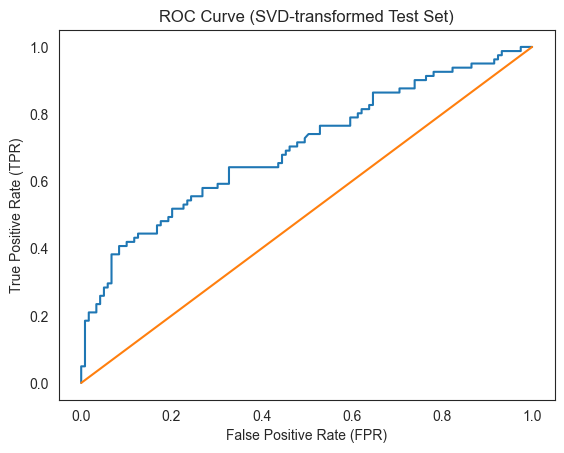

In [17]:
# Apply SVD first [ / 4 marks]
n_components = 10
svd = TruncatedSVD(n_components=n_components, random_state=seed)
train_svd = svd.fit_transform(np.asarray(tfidf_train))
test_svd = svd.transform(np.asarray(tfidf_test))

#Train and test using model LogisticRegressionCV [ /4 marks]
logreg_svd = LogisticRegressionCV(penalty='l2', random_state=seed)
logreg_svd.fit(train_svd, y_train)
probas_svd = logreg_svd.predict_proba(test_svd)[:, 1]

# Plot ROC curve and compute AUC score [ /4 marks]
auc_score_svd = roc_auc_score(y_test, probas_svd)
print(f'AUC Score (SVD): {auc_score_svd:.4f}')
fpr_svd, tpr_svd, thresholds_svd = roc_curve(y_test, probas_svd)

# Create and show the plot
plt.plot(fpr_svd, tpr_svd)
plt.plot([0, 1], [0, 1])
plt.title('ROC Curve (SVD-transformed Test Set)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()


### Question 2.3 [ /12 marks]
Train a regularized logistic regression over the UMAP-reduced dataset (with 10 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

/Users/david/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


AUC Score (UMAP): 0.6701


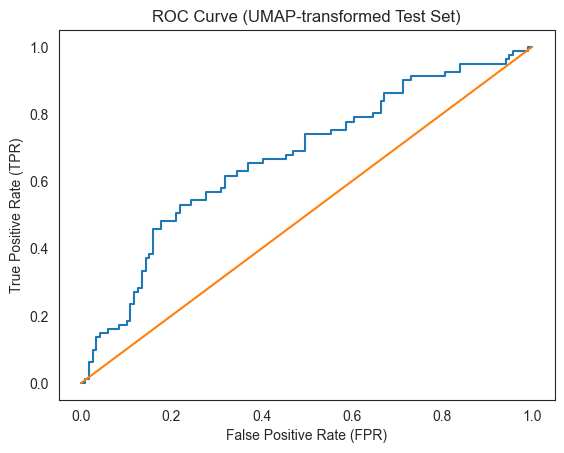

In [18]:
# Apply UMAP first [ / 4 marks]
umap_model = umap.UMAP(
    n_neighbors=best_n_neighbors,
    min_dist=best_min_dist,
    n_components=10,
    metric='cosine',
    random_state=seed,
    low_memory=False
)
train_umap = umap_model.fit_transform(train_tfidf_transformed)
test_umap = umap_model.transform(test_tfidf_transformed)


#Train and test using model LogisticRegressionCV [ /4 marks]
logreg_umap = LogisticRegressionCV(penalty='l2', random_state=seed)
logreg_umap.fit(train_umap, y_train)


# Plot ROC curve and compute AUC score [ /4 marks]
probas_umap = logreg_umap.predict_proba(test_umap)[:, 1]
auc_score_umap = roc_auc_score(y_test, probas_umap)
print(f'AUC Score (UMAP): {auc_score_umap:.4f}')
fpr_umap, tpr_umap, thresholds_umap = roc_curve(y_test, probas_umap)

# Create and show the plot
plt.plot(fpr_umap, tpr_umap)
plt.plot([0, 1], [0, 1])
plt.title('ROC Curve (UMAP-transformed Test Set)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### Question 2.4 [ /8 marks]
**Written Question:** Compare the performance of the three models. Which one is the best. [ / 2 marks] 

**Your Answer:**  It appears that the first model (with no compression) is the best, with the highest AUC score.